                                                 NATURAL LANGUAGE PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
ama=pd.read_csv("amazonreviews.tsv",sep="\t")
ama

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
9995,pos,A revelation of life in small town America in ...
9996,pos,Great biography of a very interesting journali...
9997,neg,Interesting Subject; Poor Presentation: You'd ...
9998,neg,Don't buy: The box looked used and it is obvio...


In [3]:
ama.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [4]:
ama.describe()

,label,review
count,10000,10000
unique,2,10000
top,neg,Early Hopkins story still sends chills through...
freq,5097,1


In [5]:
ama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  object
 1   review  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [6]:
ama.isnull().sum()

label     0
review    0
dtype: int64

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Cleaning :

Drop duplicates :

In [8]:
ama.drop_duplicates(inplace=True)

Drop missing values in review 

In [9]:
ama.dropna(subset=["review"])

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
9995,pos,A revelation of life in small town America in ...
9996,pos,Great biography of a very interesting journali...
9997,neg,Interesting Subject; Poor Presentation: You'd ...
9998,neg,Don't buy: The box looked used and it is obvio...


In [10]:
ama.shape

(10000, 2)

Text Preproceesing Function:

In [11]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

ama['clean_review'] = ama['review'].apply(clean_text)


Encode Target Variables:

In [12]:
ama['label']=ama['label'].map({"pos": 1,"neg": 0})
print(ama['label'].value_counts())

label
0    5097
1    4903
Name: count, dtype: int64


Exploratory Data Analysis :

Sentiment Distribution :

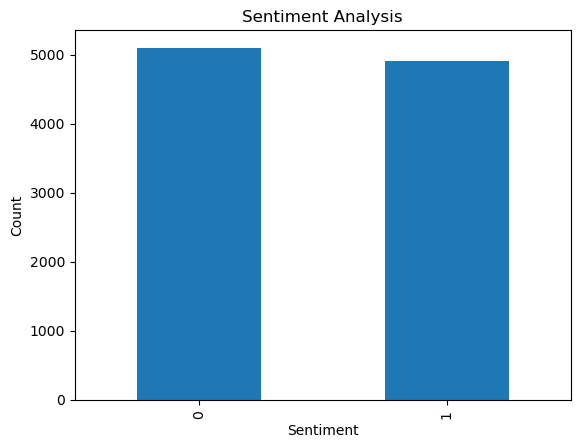

In [13]:
ama['label'].value_counts().plot(kind="bar",title="Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Word Clouds:

In [14]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [15]:
from wordcloud import WordCloud

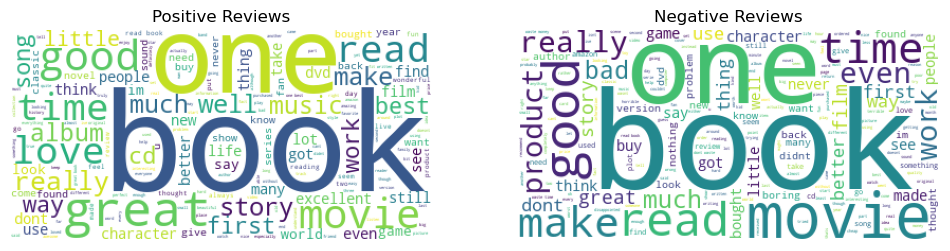

In [16]:
pos_text = ' '.join(ama[ama['label'] == 1]['clean_review'])
neg_text = ' '.join(ama[ama['label'] == 0]['clean_review'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Positive Reviews")
plt.imshow(WordCloud(background_color='white').generate(pos_text))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Negative Reviews")
plt.imshow(WordCloud(background_color='white').generate(neg_text))
plt.axis('off')

plt.show()


Train Test Split :

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    ama['review'],
    ama['label'],
    test_size=0.2,
    random_state=42,
    stratify=ama['label']
)


TF-IDF Feature Extraction :

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [20]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


Logistic Regression Model :

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

In [22]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

lr_preds = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))


Logistic Regression Accuracy: 0.8585
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1019
           1       0.85      0.86      0.86       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



Cross-Validation with Logistic Regression :

In [23]:
X = ama['review']
y = ama['label']

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

In [25]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('model', LogisticRegression(max_iter=1000))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_cv_scores = cross_val_score(
    lr_pipeline,
    X,
    y,
    cv=skf,
    scoring='f1'
)

print("Logistic Regression CV F1 Scores:", lr_cv_scores)
print("Mean F1 Score:", lr_cv_scores.mean())


Logistic Regression CV F1 Scores: [0.87278256 0.86073298 0.86594761 0.86788618 0.87817259]
Mean F1 Score: 0.8691043856640391


In [26]:
from sklearn.svm import LinearSVC

Support Vector Machine:

In [27]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

svm_preds = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


SVM Accuracy: 0.8605
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1019
           1       0.86      0.86      0.86       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



Cross-Validation with Linear SVM

In [29]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('model', LinearSVC())
])

svm_cv_scores = cross_val_score(
    svm_pipeline,
    X,
    y,
    cv=skf,
    scoring='f1'
)

print("SVM CV F1 Scores:", svm_cv_scores)
print("Mean F1 Score:", svm_cv_scores.mean())


SVM CV F1 Scores: [0.8733536  0.86517439 0.86489253 0.8650276  0.86552073]
Mean F1 Score: 0.8667937675681591


Cross-Validation Results Summary

In [30]:
cv_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVM'],
    'Mean F1 Score': [
        lr_cv_scores.mean(),
        svm_cv_scores.mean()
    ]
})

print(cv_results)


                 Model  Mean F1 Score
0  Logistic Regression       0.869104
1           Linear SVM       0.866794


Final Model Comparison :

In [31]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVM'],
    'Accuracy': [
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, svm_preds)
    ]
})

print(results)


                 Model  Accuracy
0  Logistic Regression    0.8585
1           Linear SVM    0.8605
